Absolute magnitude is defined to be the apparent magnitude an object would have if it were located at a distance of 10 parsecs.
In astronomy, absolute magnitude (M) is a measure of the luminosity of a celestial object on an inverse logarithmic astronomical magnitude scale.

In [1]:
import time
import numpy as np
import h5py
import hdf5plugin
import pandas as pd
import os 
import csv
import resource

import matplotlib as mpl
import matplotlib.colors as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from unyt import yr, Myr, kpc, arcsec, nJy, Mpc, Msun, erg, s, Hz, kelvin
from astropy.cosmology import Planck18 as cosmo

from synthesizer.emission_models import (
    AttenuatedEmission,
    CharlotFall2000,
    EmissionModel,
    BimodalPacmanEmission,
    IncidentEmission,
    NebularEmission,
    ReprocessedEmission,
    StellarEmissionModel,
)
from synthesizer.emission_models.dust.emission import Blackbody, Greybody
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.filters import UVJ
from synthesizer.grid import Grid
from synthesizer.sed import Sed
from synthesizer.particle import Gas, Stars
from synthesizer.filters import Filter, FilterCollection
from synthesizer.sed import combine_list_of_seds
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.kernel_functions import Kernel
from synthesizer.conversions import lnu_to_absolute_mag

current_directory = os.getcwd()
print("Current directory:", current_directory)


Current directory: /home/jovyan/camels/bin/LH_Pre_Update/get_LF


# Start the timer
start_time = time.time()


In [2]:

# Alternative method for LF:
# try this method again, but using AB mag instead of mass, and suply your own bins (up to -17, say)
def calc_lf(ab_mag, volume, massBinLimits):
# OG:        hist, dummy = np.histogram(np.log10(mstar), bins = massBinLimits)
        hist, dummy = np.histogram(ab_mag, bins = massBinLimits)
        hist = np.float64(hist)
        phi = (hist / volume) / (massBinLimits[1] - massBinLimits[0])
        phi_sigma = (np.sqrt(hist) / volume) /\
                    (massBinLimits[1] - massBinLimits[0]) # Poisson errors
        return phi, phi_sigma, hist
    


phi_arr =[] #phi
phi_sigma_arr =[] # phi_sigma
hist_arr = [] # hist
z_arr = [] #redshift_074, 
abs_mag_arr = [] #absolute mag (th filter)
Vcom_arr = [] # comoving vol
massBinLimits_arr = []


len(phi_arr)

In [3]:
# get grid for all galaxies
# gives grid of metalicity and age which is used to map on our camels galaxies
grid_dir = "/home/jovyan/"
#grid_name = "bc03-2016-Miles_chabrier-0.1-100.hdf5"
grid_name = "bc03_chabrier03-0.1,100.hdf5"
#grid_dir = "/Users/am/Documents/CAMELS/data/grids"

# Create a new grid
#grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

# instead of using a filter, which requires us to load in large SEDs first, pass the grid wavelength
#filt1 = Filter("top_hat/filter.1", lam_min=1400, lam_max=1600, new_lam=grid.lam)
#filt_lst = [filt1]

# Define a new set of wavelengths
lims_lams=(1400, 1600)

grid = Grid(grid_name, grid_dir=grid_dir, lam_lims=lims_lams, read_lines=False)
print(grid.shape)


(221, 6, 22)


In [4]:
# Define the directory where the text files will be saved
output_dir = "/home/jovyan/camels/bin/LH_Pre_Update/get_LF/output/"


In [5]:

# get gals
LH_X = 'LH_104'
dir_ = '/home/jovyan/Data/Sims/IllustrisTNG/LH/' + LH_X
gals_074 = load_CAMELS_IllustrisTNG(
    dir_,
    snap_name='snapshot_074.hdf5', 
    group_name='groups_074.hdf5',
    verbose=False,
)

/srv/conda/envs/notebook/lib/python3.9/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


LH_104 = 'LH_104'
dir_ = '/home/jovyan/Data/Sims/IllustrisTNG/LH/' + LH_104
gals_104 = load_CAMELS_IllustrisTNG(
    dir_,
    snap_name='snapshot_074.hdf5', 
    fof_name='groups_074.hdf5',
    verbose=False,
)

# this is long dont need to print this.
for gal in gals_074:
    print(f"Galaxy has {gal.stars.nstars} stellar particles")
    print(f"Galaxy has {gal.gas.nparticles} gas particles")


gals_074

In [10]:

# Filter galaxies to only include those with 100 or more star particles
gals_074 = [gal for gal in gals_074 if gal.stars.nstars >= 100]
print(len(gals_074))
gals_074 = [gal for gal in gals_074 if gal.gas.nparticles >= 100]


147


# -1.68397285e+02
for gal in gals_074:
    print(gal.stars.ages)

# commented out to see if Chris fix and my environment are working:

#gals_cp = [gal for gal in gals_cp if gal.stars.ages >= 0] # found some negative data in gal[276] for LH_50, try this to fix.



# Assuming gals_cp is a list or array containing multiple galaxies
for gal in gals_074:
    # Access the Stars object for the current galaxy
    stars = gal.stars
    
    # Access the relevant attributes
    initial_masses = stars.initial_masses
    ages = stars.ages
    metallicities = stars.metallicities

    # Create a mask for stars with non-negative initial_masses and positive ages
    mask = (initial_masses >= 0) & (ages > 0)
    
    # Apply the mask to all relevant attributes
    cleaned_initial_masses = initial_masses[mask]
    cleaned_ages = ages[mask]
    cleaned_metallicities = metallicities[mask]
    
    # Create a new Stars object with the cleaned data
    cleaned_stars = Stars(initial_masses=cleaned_initial_masses, ages=cleaned_ages, metallicities=cleaned_metallicities)
    
    # Update the stars attribute of the current galaxy with the cleaned Stars object
    gal.stars = cleaned_stars

    # Optionally print the cleaned ages to verify
    print(cleaned_stars.ages)



#gals_074 = [gal for gal in gals_074 if gal.stars.ages >= 100] # found some negative data in gal[276] for LH_50, try this to fix.
gals_test = [gal for gal in gals_074 if all(age >= 100 for age in gal.stars.ages)]


for gal in gals_074:
    print(gal.stars.ages)

# THIS SHOULDNT BE NEEDED SINCE UPDATE
# Iterate through each galaxy in gals_074 with an index
for index, gal in enumerate(gals_074):
    # Access the ages array of the stars in the current galaxy
    ages = gal.stars.ages
    
    # Find the negative values in the ages array
    negative_ages = ages[ages < 0]
    
    # If there are any negative values, print them
    if negative_ages.size > 0:
        print(f"Galaxy Index: {index}")
        print("Negative ages:", negative_ages)


gals_cp = gals_074 

# Remove stars from each galaxy where the age is less than 100
for gal in gals_cp:
    obj = gal.stars.ages
    #print(obj)
    cleaned_obj = [arr[arr >= 0] for arr in obj]
    gal.stars.ages = cleaned_obj
    print(gal.stars.ages)
    


gals_test = [gal for gal in gals_074 if all(metallicities >=1e-6 for metallicities in gal.stars.metallicities)]

# found some very small metalcities also (7.16442446e-06 to -10)
#gals_074 = [gal for gal in gals_074 if gal.stars.metallicities >=1e-6]

for gal in gals_074:
    print(gal.gas.nparticles)
    print(gal.stars.nstars)

# Assuming your list of Galaxy objects is named 'gals_074'
for index, galaxy in enumerate(gals_074):
    print("Gal: [", index , ']')

In [13]:
# try different method to get specs:
#specs = np.vstack([g.stars.get_spectra_incident(grid).lnu for g in gals_074])
#print(specs)

In [14]:
g = gals_074[137]
print(g)

+---------------------------------------------------------------------------------------------+
|                                           GALAXY                                            |
+-------------------------------+-------------------------------------------------------------+
| Attribute                     | Value                                                       |
+-------------------------------+-------------------------------------------------------------+
| galaxy_type                   | 'Particle'                                                  |
+-------------------------------+-------------------------------------------------------------+
| stars                         | <synthesizer.particle.stars.Stars object at 0x7f0de1e06be0> |
+-------------------------------+-------------------------------------------------------------+
| gas                           | <synthesizer.particle.gas.Gas object at 0x7f0dbb109520>     |
+-------------------------------+-------

In [15]:
print(type(g))

<class 'synthesizer.particle.galaxy.Galaxy'>


In [16]:
print(g.stars.initial_masses)


[35784444. 10046882. 35729828. 24234642. 28452670. 26559054. 20050398.
 28736250. 28479760. 31694732. 13933997. 25009610. 23550900. 16070881.
 20925284. 21255214. 31317708. 20077630. 26360406. 20204594. 24747696.
 24181034. 19314928. 23426320. 21775454. 31532226. 25994324. 24603788.
 17130586. 24406598. 17439444. 26653368. 37304372. 30248602. 28654848.
 22211396. 26582392. 31003906. 19641748. 26947720. 24179976. 21050012.
 21305606. 32369742. 22641816. 34298952. 29898632. 15424778. 18634790.
 20170590. 25213044. 14839478. 25185608. 19328002. 25405636. 18164074.
 23087704. 31421402. 32947592. 30431308. 23710870. 27279966. 28912910.
 19775624. 29653470. 27943758. 15706061. 28598480. 26599314. 30384394.
 33439152. 26910966. 20623334. 35205424. 19659044. 24442396. 28492834.
 23413170. 32271832. 32252990.  7430425. 35945540. 28166552. 18873400.
 23230088. 32815802. 15253708. 28593720. 28720990. 36279220. 26684304.
 19127744. 30529028. 25074568. 16075368. 10969922. 27358878. 16372039.
 28395

In [17]:
print(g.stars.ages)


[5.69026226e+09 4.55760002e+09 6.43790999e+09 7.26794471e+09
 6.59842295e+09 6.76937803e+09 5.60865798e+09 1.14891045e+09
 7.63309591e+09 7.62748846e+09 1.14664869e+09 7.35340190e+09
 5.35798490e+09 5.35187499e+09 6.28714761e+09 2.47701809e+08
 7.62523855e+09 5.88545611e+08 6.22016408e+09 5.08612888e+09
 8.07918470e+09 1.44380431e+09 5.43801059e+09 6.84110691e+09
 8.25466098e+09 6.86269690e+09 6.87340850e+09 4.57049319e+09
 5.57287909e+09 1.50362149e+09 1.43501857e+09 6.62449646e+09
 2.34304967e+09 4.40202696e+09 2.58243709e+09 4.99515911e+09
 7.29363621e+09 4.39440267e+09 4.49260555e+09 5.65251660e+09
 4.35610566e+09 5.64970373e+09 4.46259904e+09 6.52676787e+09
 7.95471666e+08 1.25465072e+09 3.12921168e+08 5.70267058e+08
 2.66562624e+07 5.38408317e+08 1.32897240e+09 4.82442741e+08
 1.47011179e+09 4.87250580e+08 1.03749297e+09 4.58374148e+08
 1.58904521e+09 5.23230749e+09 5.10408377e+09 3.24316638e+09
 3.58397361e+09 2.54133135e+09 4.63262060e+09 5.41403325e+09
 3.62364249e+09 1.888222

In [18]:
print(g.stars.metallicities)

[3.18072666e-03 5.57395723e-03 3.62171466e-03 3.33565357e-03
 2.34390516e-03 3.39714182e-03 4.79144230e-03 2.15196540e-03
 1.63525797e-03 1.72037701e-03 2.63621379e-03 3.37845157e-03
 5.76980691e-03 5.33247460e-03 3.95644084e-03 3.90741788e-03
 1.53119559e-03 4.36312007e-03 5.51010389e-03 5.77896647e-03
 4.19687538e-04 1.61052449e-03 1.39559206e-05 2.59958756e-06
 7.98888067e-10 1.57155027e-05 9.44466970e-04 4.50819614e-04
 2.60537886e-03 1.38388551e-03 1.67325197e-03 1.90138852e-03
 1.40516052e-03 5.01146133e-04 1.43561745e-03 1.43631805e-05
 8.19841528e-10 1.20059948e-03 6.90769157e-05 2.72337911e-06
 2.20863032e-03 2.72636044e-06 3.58425576e-04 1.64353033e-03
 3.46188736e-03 2.25300761e-03 5.03063668e-03 4.10348177e-03
 4.22061794e-03 4.05838201e-03 4.29489557e-03 4.55625961e-03
 3.32188443e-03 4.20670956e-03 4.57713334e-03 5.25696576e-03
 3.27596976e-03 2.59908265e-03 2.39696749e-03 3.14964424e-03
 2.85351346e-03 3.66501277e-03 3.26114963e-03 4.19129909e-04
 2.08370993e-03 3.432296


for gal in gals_074:
    print(f"Galaxy has {gal.stars.nstars} stellar particles")
    print(f"Galaxy gas {gal.gas.nparticles} gas particles")


In [19]:


cat_074 = dir_+'/groups_074.hdf5'
# open file
f_h5py = h5py.File(cat_074, 'r')

# read different attributes of the header
boxSize_074 = f_h5py['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
redshift_074 = f_h5py['Header'].attrs[u'Redshift']


# Get the number of star particles for each galaxy
nstars_list = [gal.stars.nstars for gal in gals_074]
# Get the number of gas particles for each galaxy
ngas_list = [gal.gas.nparticles for gal in gals_074]

# Calculate the minimum and maximum number of star particles
min_nstars = min(nstars_list)
max_nstars = max(nstars_list)

# Calculate the minimum and maximum number of gas particles
min_ngas = min(ngas_list)
max_ngas = max(ngas_list)

print(f"Minimum number of star particles: {min_nstars}")
print(f"Maximum number of star particles: {max_nstars}")
print(f"Minimum number of gas particles: {min_ngas}")
print(f"Maximum number of gas particles: {max_ngas}")


In [20]:


spec_list = []
# Lets work with z=0.475 so gals_p10
for i in gals_074:
    gal = i
    # To get a spectra we just call the `get_spectra` method on the stars with
    # whatever emission model we want to use, here the incident model.
    spec = gal.stars.get_spectra(incident)
    spec.get_fnu0()
    spec_list.append(spec)

# Combine spectra
seds = combine_list_of_seds(spec_list)



# flters:
# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
#fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
#fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# tophat filter
filt1 = Filter("top_hat/filter.1", lam_min=1400, lam_max=1600, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1]#, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)

seds.lnu  # rest frame lumd
seds.get_photo_lnu(combined_filters, verbose=True) 
#Calculate broadband luminosities using a FilterCollection object   
# conversion is done using:

#    M = -2.5 * log10(L_nu / dist_mod / (erg / s / Hz)) - 48.6

abs_mag = lnu_to_absolute_mag(seds.lnu)
abs_mag_th = abs_mag[0]

In [35]:
abs_mag_th

array([-17.61049648, -17.58217026, -17.60809374, -17.58851181,
       -17.64403813, -17.66844379, -17.66225309, -17.62667977,
       -17.61636473, -17.63265902, -17.6571199 , -17.65641697,
       -17.61100192, -17.65750048, -17.61100507, -17.55718337,
       -17.65674752, -17.6061467 , -17.57972646, -17.6328423 ,
       -17.68298693, -17.72254931])

In [22]:
# next steps, get luminosity function for these magnitudes
# co-moving volume: BoxSize_025 and redshift:
little_h =  0.6711
Vphys = (boxSize_074/little_h )**3
Vcom = Vphys * ((1+redshift_074)**3)


In [23]:

massBinLimits = np.arange(-22, -16, 0.5)
phi, phi_sigma, hist = calc_lf(abs_mag_th, Vcom, massBinLimits)
# NOTE: 074 is the same redshift as CV_0/025
massBinLimits = massBinLimits[:-1]


In [34]:
massBinLimits

array([-22. , -21.5, -21. , -20.5, -20. , -19.5, -19. , -18.5, -18. ,
       -17.5, -17. ])

In [33]:
phi

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00027056, 0.        ,
       0.        ])

In [ ]:
output_dir = "/home/jovyan/camels/LH/get_LF/output/"

# Define output file path
output_file = f"{output_dir}{LH_X}_test.txt"

# Write the data to the text file line by line
with open(output_file, 'w') as txtfile:
    # Write phi values
    txtfile.write("phi\n")
    for value in phi_l:
        txtfile.write(f"{value}\n")

    # Write phi_sigma values
    txtfile.write("phi_sigma\n")
    for value in phi_sigma_l:
        txtfile.write(f"{value}\n")

    # Write hist values
    txtfile.write("hist\n")
    for value in hist:
        txtfile.write(f"{value}\n")

    # Write massBinLimits values
    txtfile.write("massBinLimits\n")
    for value in massBinLimits:
        txtfile.write(f"{value}\n")


print('Written out: /home/jovyan/camels/play/synth-play/LH/output/',LH_X)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time, "seconds")

In [ ]:
# Get memory usage in bytes
memory_usage = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print("Memory usage end:", memory_usage/1000000, "GB")


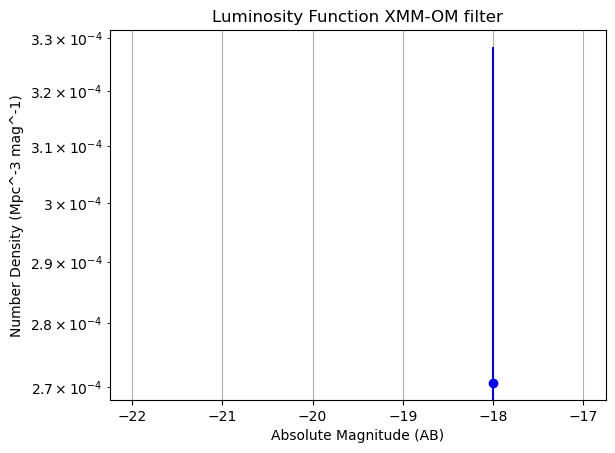

In [36]:
# will do latest LH_ set in loop as a test
label_z = 'z = 0.46'


# Plot the luminosity function
plt.errorbar(massBinLimits, phi, yerr=phi_sigma, fmt='o', color='blue',label=label_z)
plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')

plt.title('Luminosity Function XMM-OM filter')
plt.grid(True)
plt.show()